In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = (alpha + beta[0]*X1 + beta[1]*X2 
     + np.random.randn(size)*sigma)

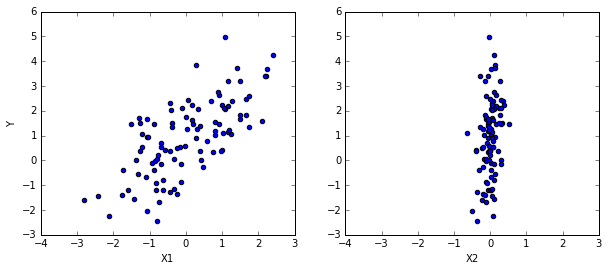

In [2]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

In [3]:
from pymc3 import Model, Normal, HalfNormal

In [4]:
basic_model = Model()

with basic_model:
    
    # Priors for unknown model parameters
    # (note: same variable names as above, but not the same 
    #  variables)
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome (A 'deterministic' r.v..)
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    # (note: This object describes the data, the value of Y
    #  given the data...)
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log to model.


In [5]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=basic_model)
print(map_estimate)

{'beta': array([ 0.948486  ,  2.60705513]), 'sigma_log': array(-0.03278146854842082), 'alpha': array(0.9065985664354854)}


In [6]:
from scipy import optimize

map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)
print(map_estimate)

{'beta': array([ 0.95140146,  2.61437458]), 'sigma_log': array(-0.03000977520318259), 'alpha': array(0.9090521898978398)}


In [22]:
from pymc3 import NUTS, sample

import theano
theano.config.blas.ldflags = ''
print(theano.config.blas.ldflags)

with basic_model:
    
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    
    # draw N posterior samples
    N = 15000
    trace = sample(N, start=start)


Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log
 [-----------------100%-----------------] 15000 of 15000 complete in 16.3 sec

In [23]:
trace['alpha'][-5:]

array([ 0.91438052,  0.86573736,  0.87427833,  0.9280884 ,  1.003819  ])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11be2dac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c1d4b70>]], dtype=object)

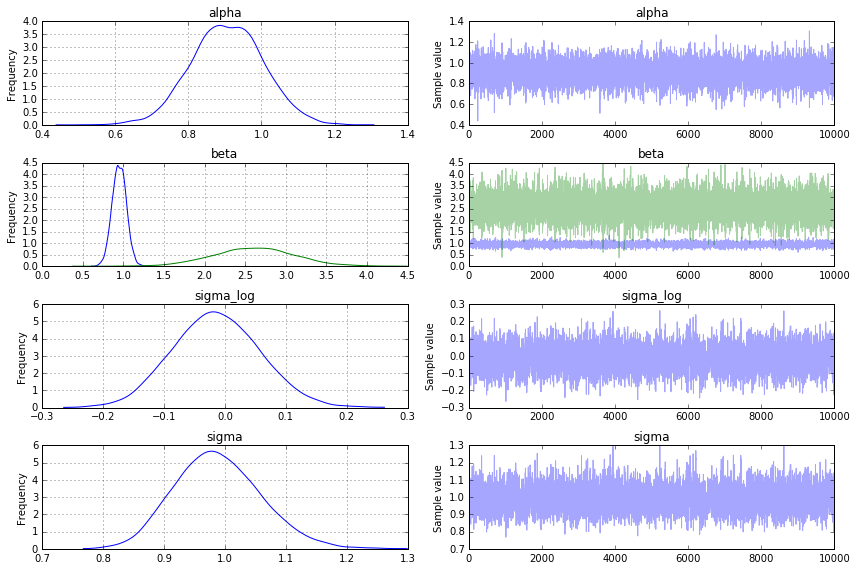

In [24]:
from pymc3 import traceplot

traceplot(trace[5000:])

In [20]:
from pymc3 import summary

summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.906            0.097            0.001            [0.721, 1.100]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.716          0.842          0.907          0.972          1.096


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.949            0.086            0.001            [0.788, 1.120]
  2.605            0.515            0.005            [1.543, 3.559]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.783          0.891          0.950          1.008          1.116
  1.580          2.264          2.607   

$$Normal = \frac{1}{\sqrt{2 \pi} \sigma} e^{\frac{x-\mu}{2}}$$